# Data preprocessing and exploration

### Reads in the April 2018 summary data from an excel file (renamed to /datasets/ActivatedInsights/ActivatedInsight.xlsx)¶

- Select the appropriate column
- Perform the appropriate transformation (for skewed data)
- Normalize and standardize the data

### Add median household income for each location using U.S. Census Data.

- Choose the appropriate value based on the zip code for each location.
- Perform the log transform
- Normalize the data

### Save original and transformed data, together with the transform (as .pkl file)

- Save original values for the employee answers and turnover rate.
- Save the transformed features.
- Save the transform function.

### Explore correlations between the answers to the questions. Additional exploration of data

- Show correlation matrix, mean correlation values.
- Show relationships between key values.

In [1]:
#Import necessary packages

import numpy as np
import pandas as pd
import os
import pickle

import matplotlib.pyplot as plt
import seaborn as sb
color = sb.color_palette()
%matplotlib inline

from sklearn import preprocessing as pp 
from scipy.stats import pearsonr


### Read in the original data file received. The name of the file was changed to ActivatedInsight.xlsx. It is located under /dataset/ActivatedInsights/

In [2]:
#Read Excel data to pandas dataframe provided. Read the first tab.
current_path = os.getcwd()
file = '/datasets/ActivatedInsights/ActivatedInsight.xlsx'
data1 = pd.read_excel(current_path + file)

### During the read process, some rows gets shifted. Correct for the row shift and select appropriate columns.

In [3]:
#First two rows are excel column names that only exists for some columns. Remove them for now.
#Also some of the last few rows have no data.
data2 = data1.iloc[2:-13]

#Columns containing Tenure months for the GM, Chef, Sales, Office Managers (some missing values)
TenureMonth = data2.iloc[:,[6,8,10,12]]

# dataX will be just the Questionare answers
dataX = data2.iloc[:,13:]

# dataY will be just the occupany column
dataY = data2.iloc[:,3]

#LocationCode will contain the column for the location code
LocationCode = data2.iloc[:,2]

# TurnOver will contain the turn over rate
TurnOver = data2.iloc[:,4]

### Currently the data type is "object". Convert to float.

In [4]:
#Change the data type to float (from object).

#For occupancy rate.
dataY2=(pd.to_numeric(dataY, errors='coerce'))
#For location code.
LocationCode2=(pd.to_numeric(LocationCode, errors='coerce'))
#For turnover rate.
TurnOver2=(pd.to_numeric(TurnOver, errors='coerce'))

In [5]:
#Change the data type to float for the Employee Answers
dataX2 = pd.DataFrame().reindex_like(dataX)

#Run a for loop to change each column to float type
for index in range(dataX.shape[1]):
   
   # Select column by index position using iloc[]
    dataX2.iloc[:,index] = (pd.to_numeric(dataX.iloc[:,index], errors='coerce'))


In [6]:
#Do the same for the Tenure data frame.
TenureMonth2 = pd.DataFrame().reindex_like(TenureMonth)

#Run a for loop to change each column to float type
for column in range(TenureMonth.shape[1]):
   
   # Select column by index position using iloc[]
    TenureMonth2.iloc[:,column] = (pd.to_numeric(TenureMonth.iloc[:,column], errors='coerce'))

## Read in the U.S. Census Data. Currently uses just the median household income. Downloaded the 2017 data (latest available for all Zip Code Tabulated Area) as .csv file

In [7]:
# Read csv for the median income 
file = '/datasets/ActivatedInsights/ACS175YRS1903.csv'
IncomeData = pd.read_csv(current_path + file, header=1)

### Original excel file contains a tab for maching the location code to zip code. Use it to convert location code to zip code and then get the median household income for each location

In [8]:
# Read the sheet for the location code to zip code mapping
current_path = os.getcwd()
file = '/datasets/ActivatedInsights/ActivatedInsight.xlsx'
CodeToZip = pd.read_excel(current_path + file, sheet_name = 5, header = 1)

In [9]:
#Make new dataframe for "location code to zip code" matching. Convert from "object" to "float" 
CodeToZipNumeric = pd.DataFrame().reindex_like(CodeToZip)

#Run a for loop to change each column to float type
for index in range(CodeToZip.shape[1]):
   
   # Select column by index position using iloc[]
    CodeToZipNumeric.iloc[:,index] = (pd.to_numeric(CodeToZip.iloc[:,index], errors='coerce'))



### Find median household income for each location.

In [10]:
#Rename the column for the mdian income
IncomeData.rename(columns={'Median income (dollars); Estimate; Households': 'MedianIncome'}, inplace=True)

#GO through all the location data and make an array that contains the median income.

#First reset the index of the LocationCode
LocationCode3=LocationCode2.reset_index(drop=True)

#make a new series with same shape as LocationCode. This will contain Median Income Data
#MedianIncomeData = pd.DataFrame().reindex_like(dataY3)
RowIndex1=range(LocationCode3.shape[0])
MedianIncomeData = pd.DataFrame(columns=['MedianIncomeForZip'], index=RowIndex1)
 
#for loop to get the Median income for each location's zip code.
for row in range(LocationCode3.shape[0]):
    
    ZipCode=CodeToZip.loc[CodeToZip['Code'] == LocationCode3[row],:]
    #Zip Code actually is a big list of all the rows that had the location code.
    #They should all point to the same zip code (in the second column) so chose the top one.
    ZipCodeSelect=ZipCode.iloc[0,1]
    
    #Get the value for the median income corresponding to the ZipCodeSelect
    MedianIncomeValue1 = IncomeData.loc[ IncomeData['Id2'] == ZipCodeSelect , 'MedianIncome' ]
    #make it numeric
    MedianIncomeValue2=pd.to_numeric(MedianIncomeValue1, errors='coerce')
    MedianIncomeData.iloc[row]=MedianIncomeValue2.iloc[0]

## Tenure month for key employee has some missing values. Replace missing values with median values for each category.

In [11]:
#Check where the missing values are.
TenureMonth2.loc[(TenureMonth2['Unnamed: 6'].isnull()) |
              (TenureMonth2['Unnamed: 8'].isnull()) |
              (TenureMonth2['Unnamed: 10'].isnull()) |
              (TenureMonth2['Unnamed: 12'].isnull())]

,Unnamed: 6,Unnamed: 8,Unnamed: 10,Unnamed: 12
6,13.0,36.0,66.0,NaN
31,14.0,80.0,7.0,NaN
35,138.0,NaN,14.0,12.0
41,34.0,29.0,37.0,NaN
43,61.0,21.0,NaN,7.0
46,24.0,137.0,0.0,NaN
49,79.0,127.0,NaN,13.0
51,92.0,12.0,NaN,32.0
53,49.0,10.0,NaN,43.0
54,0.0,NaN,4.0,27.0


In [12]:
#Replace the missing data for Tenure of GM with median values.
MedianTenureGM = TenureMonth2.loc[:,'Unnamed: 6'].median()

TenureMonth2.loc[(TenureMonth2.loc[:,'Unnamed: 6'].isnull())] = MedianTenureGM
#Rename the column
TenureMonth2.rename(columns={'Unnamed: 6': 'GM Tenure'}, inplace=True)

In [13]:
#Replace the chef, sales leader, and office manager's missing tenure with their median
MedianTenureChef = TenureMonth2.loc[:,'Unnamed: 8'].median()
MedianTenureSales = TenureMonth2.loc[:,'Unnamed: 10'].median()
MedianTenureOffice = TenureMonth2.loc[:,'Unnamed: 12'].median()

TenureMonth2.loc[(TenureMonth2.loc[:,'Unnamed: 8'].isnull())] = MedianTenureChef
TenureMonth2.loc[(TenureMonth2.loc[:,'Unnamed: 10'].isnull())] = MedianTenureSales
TenureMonth2.loc[(TenureMonth2.loc[:,'Unnamed: 12'].isnull())] = MedianTenureOffice

#Rename the column
TenureMonth2.rename(columns={'Unnamed: 8': 'Chef Tenure'}, inplace=True)
TenureMonth2.rename(columns={'Unnamed: 10': 'Sales Tenure'}, inplace=True)
TenureMonth2.rename(columns={'Unnamed: 12': 'Office Manager Tenure'}, inplace=True)

## Save the original values for the turnover rate and employee responses, before transforming the data

In [14]:
with open('original_values.pickle', 'wb') as f:
    pickle.dump([TurnOver2, dataX2], f)

## Check the data distribution and transform the data to make it normally distributed

### Start with tenure months, which is highly positively skewed

''

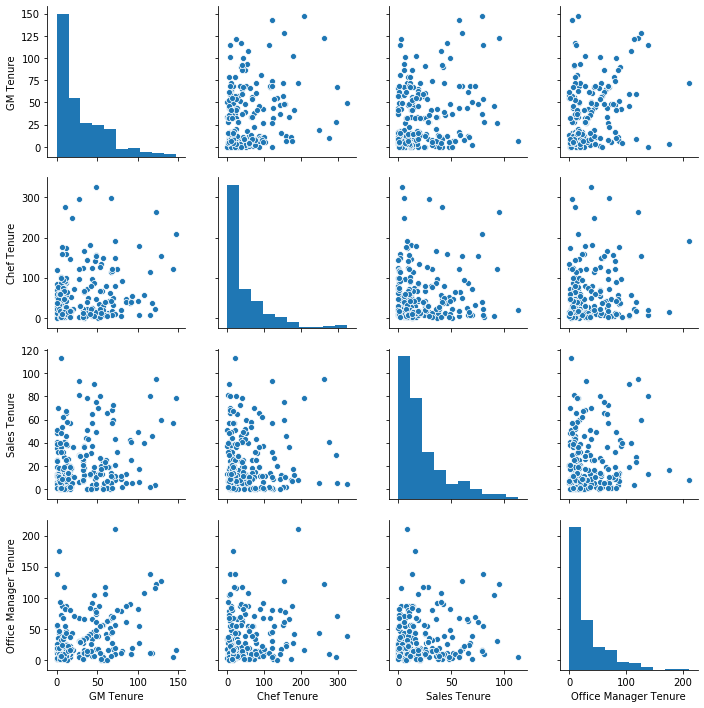

In [15]:
#Tenure monthes are extrenely poistively skewed. Use log transform
sb.pairplot(TenureMonth2)
;

### Log transform the tenure months. Because tenure month could be 0, add 0.1 to avoid having to deal with the log of zero (= negative infinity)

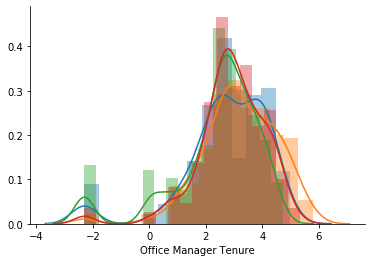

In [16]:
#log transform the TenureMonth values after adding 0.1 so that we don't have to deal with the log of zero.
NewTenureMonth2=TenureMonth2+0.1
NewTenureMonth2Log=NewTenureMonth2.apply(np.log) # returns DataFrame
#Show the new distribution.
for column in NewTenureMonth2Log:
    sb.distplot(NewTenureMonth2Log.loc[:,column])
    sb.despine()

## Median income data is also positively skewed. Apply log transform.

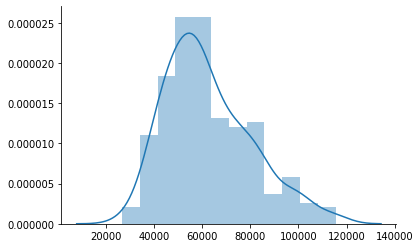

In [17]:
#show the distribution of Median income. It's also positively skewed (but no zero value)
sb.distplot(MedianIncomeData)
sb.despine()

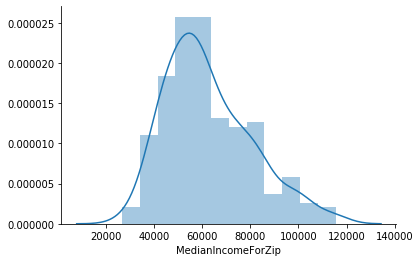

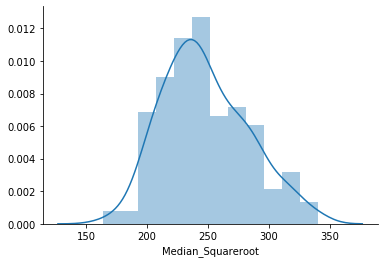

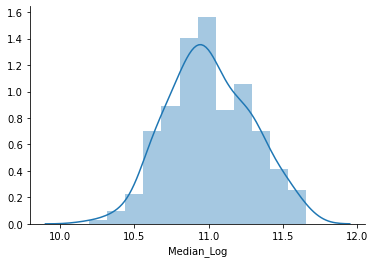

In [18]:
#To correct for positive skew, try both sqrt and log transform.
#Apply sqrt
MedianIncomeData['Median_Squareroot']=MedianIncomeData['MedianIncomeForZip']**(1/2)
#Take log
MedianIncomeData['Median_Log']=np.log(MedianIncomeData['MedianIncomeForZip'])

#Show the distribution. Log transform seems to work the best.
for column in MedianIncomeData:
    plt.figure()
    sb.distplot(MedianIncomeData.loc[:,column])
    sb.despine()

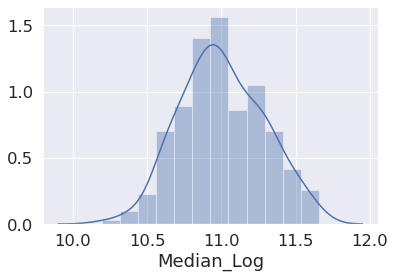

In [19]:
#Save the hisogram for the log transformed median income.
sb.set(font_scale=1.5)
sb.distplot(MedianIncomeData.iloc[:,2])
plt.savefig("MedianIncomeLog.png")

## Turnover rate is also positively skewed (also contain zero). Take Log transform. Add 0.1 to avoid dealing with log of zero (same situation as in tenure months)

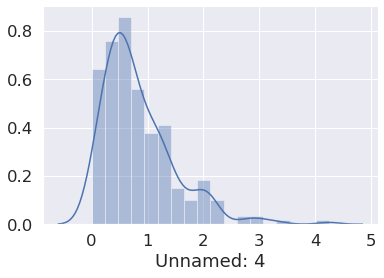

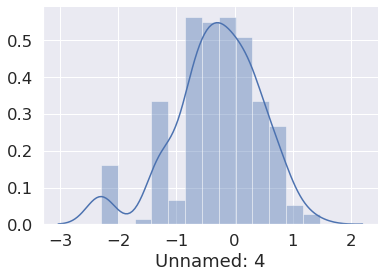

In [20]:
#Turnover rate is positively skewed
plt.figure()
sb.distplot(TurnOver2)
sb.despine()

#apply log transform after adding 0.1 (to avoid zero)
LogTurnover=np.log(TurnOver2+0.1)
plt.figure()
sb.distplot(LogTurnover)
sb.despine()

## Room occupancy rate is negatively skewed (can't go over 100%). Flip the values, take log, then flip back.

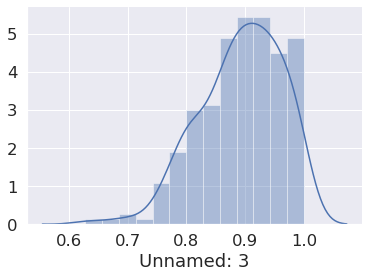

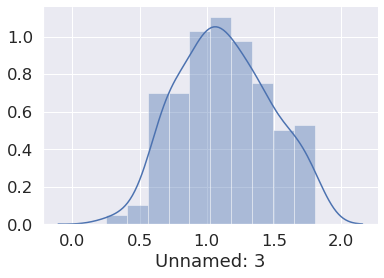

In [21]:
#For room occupancy.
plt.figure()
sb.distplot(dataY2)
sb.despine()

#it's negatively skewed so flip, take log, then flip back.
dataY2Flip=1.1-dataY2
dataY2Log=np.log(dataY2Flip)
OccupancyLogFlip=-0.5-dataY2Log

#After the transform.
plt.figure()
sb.distplot(OccupancyLogFlip)
sb.despine()

## Score for employee responses are also negatively skewed. Flip the values, take log transform, then flip it back

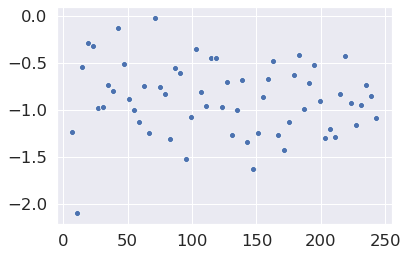

In [22]:
#Employee response featres are all negatively skewed.
skewValue = dataX2.skew(axis=0)
sb.scatterplot(data=skewValue)

In [23]:
#For the DataX, because they are mostly negative, flip it by subtracting it from 1.1 and then use log transform.
#After that flip back again by subtracting it from another value.
NewDataX2=1.1-dataX2
NewDataX2Log=NewDataX2.apply(np.log) # returns DataFrame
NewDataX2LogFlip=0.1-NewDataX2Log


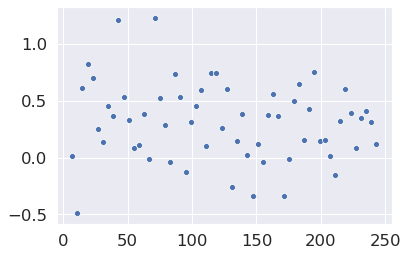

In [24]:
#Skew value reduced, but now some are too positively skewed. Consider more adaptive strategy next time.
skewValue_new = NewDataX2LogFlip.skew(axis=0)
sb.scatterplot(data=skewValue_new)

## Most variables are now close to normally distributed. Standaridize it by subtracting the mean and dividing by the standard deviation.

In [25]:
#Now we have more or less normally distributed input variables.
#We have NewDataX3LogFlip for the employee response
#We have LogTurnover for the turnover rate.
#We have OccupancyLogFlip for the occupancy.
#We have MedianIncomeData['Median_Log']=np.log(MedianIncomeData['MedianIncomeForZip']) for Median Income Data
#We have NewTenureMonth3Log

#Standarize
scalerEmployeeResponse = pp.StandardScaler().fit(NewDataX2LogFlip)
EmployeeResponse = scalerEmployeeResponse.transform(NewDataX2LogFlip)
EmployeeResponseDF=pd.DataFrame(data=EmployeeResponse)

scalerMedianIncomeData = pp.StandardScaler().fit(MedianIncomeData)
MedianIncomeDataS = scalerMedianIncomeData.transform(MedianIncomeData)
MedianIncomeDataSDF=pd.DataFrame(data=MedianIncomeDataS)

scalerTenureMonth = pp.StandardScaler().fit(NewTenureMonth2Log)
TenureMonthS = scalerTenureMonth.transform(NewTenureMonth2Log)
TenureMonthSDF=pd.DataFrame(data=TenureMonthS)

OccupancyTurnover=pd.concat([OccupancyLogFlip, LogTurnover], axis=1)

scalerOccupancyTurnover = pp.StandardScaler().fit(OccupancyTurnover)
OccupancyTurnoverS = scalerOccupancyTurnover.transform(OccupancyTurnover)
OccupancyTurnoverSDF=pd.DataFrame(data=OccupancyTurnoverS)



### Save the scaling factors for each variable for future use.

### Save the features for future use

In [26]:
#Save the scaling factors for future use
with open('scaler.pickle', 'wb') as f:
    pickle.dump([scalerEmployeeResponse, scalerOccupancyTurnover], f)

In [27]:
#Save the features.
feature_set = pd.concat([EmployeeResponseDF, MedianIncomeDataSDF.iloc[:,2], TenureMonthSDF], axis=1)


feature_set.to_pickle("./feature_set.pkl")
turnOverRate = OccupancyTurnoverSDF.iloc[:,1]
turnOverRate.to_pickle("./turnOverRate.pkl")
LocationCode3.to_pickle("./LocationCodeComprehensive.pkl")

### Check the correlation between the answers to the questions.


In [28]:
#this is the original data
dataX2.head()

,7,11,15,19,23,27,31,35,39,43,...,207,211,215,219,223,227,231,235,239,243
2,0.965517,0.931034,0.758621,0.758621,0.862069,0.931034,0.931034,0.862069,0.827586,0.827586,...,0.931034,0.965517,0.931034,0.758621,0.931034,0.862069,0.862069,0.896552,0.896552,0.931034
3,0.791667,0.916667,0.454545,0.521739,0.458333,0.625000,0.541667,0.434783,0.608696,0.478261,...,0.833333,0.791667,0.625000,0.625000,0.583333,0.500000,0.625000,0.608696,0.583333,0.625000
4,0.904762,0.904762,0.666667,0.761905,0.619048,0.761905,0.666667,0.714286,0.714286,0.476190,...,0.952381,0.904762,0.857143,0.714286,0.857143,0.904762,0.714286,0.761905,0.714286,0.761905
5,0.800000,0.850000,0.750000,0.750000,0.850000,0.850000,0.850000,0.800000,0.850000,0.550000,...,0.800000,0.850000,0.800000,0.850000,0.750000,0.800000,0.736842,0.750000,0.850000,0.750000
6,0.730769,0.769231,0.615385,0.730769,0.692308,0.653846,0.653846,0.653846,0.615385,0.500000,...,0.760000,0.884615,0.769231,0.615385,0.846154,0.884615,0.846154,0.653846,0.769231,0.807692


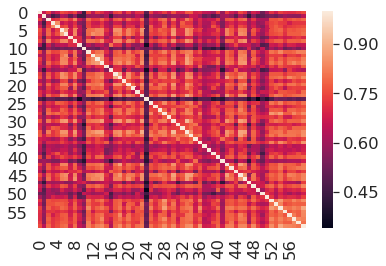

In [30]:
#Make a correlation matrix to see which questions are correlated.
#Rename the columns so it will be easier to see
dataX2.columns = range(dataX2.shape[1])
corrMatrix = dataX2.corr()
sb.heatmap(corrMatrix)

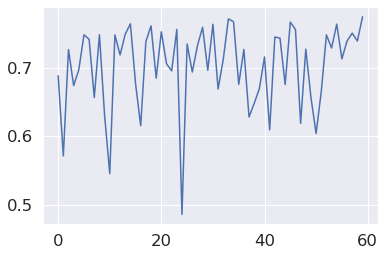

In [31]:
#plot average correlation for each question vs every other question.
mean_correlation = corrMatrix.mean()
sb.lineplot(data=mean_correlation)

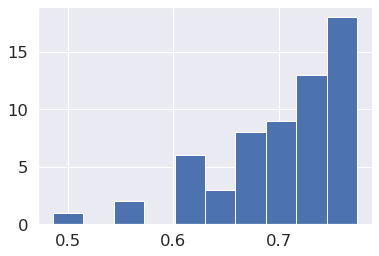

In [32]:
#plot the histogram of average correlation
#Most answers are highly correlated with each other.
mean_correlation.hist()

### Find some questions whose answers are highly correlated with each other

In [34]:
#Top 10 questions that are correlated with quesion 0 (first question)
question_ranking=corrMatrix.nlargest(10,0)
question_ranking.iloc[:,0]

0     1.000000
34    0.777867
33    0.769691
30    0.763731
18    0.752430
5     0.752427
59    0.750972
45    0.749074
11    0.746432
8     0.744939
Name: 0, dtype: float64

In [35]:
#Top 10 questions that are correlated with quesion 1 (2nd question)
question_ranking=corrMatrix.nlargest(10,1)
question_ranking.iloc[:,1]

1     1.000000
34    0.669861
35    0.661585
0     0.660508
22    0.643925
59    0.641557
5     0.631337
45    0.624104
42    0.613795
20    0.612610
Name: 1, dtype: float64

In [36]:
#Top 10 questions that are correlated with quesion 55 (56th question)
question_ranking=corrMatrix.nlargest(10,55)
question_ranking.iloc[:,55]

55    1.000000
59    0.836014
54    0.816445
34    0.803092
36    0.795568
57    0.790176
52    0.785941
11    0.780442
28    0.774448
58    0.773390
Name: 55, dtype: float64

### Plot some key features against the turnover rate (raw values)

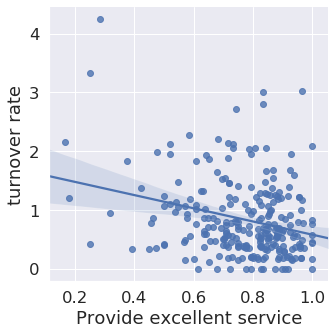

In [37]:
#Put together into a single data frame so we can plot easier
frameMVP = { 'turnover rate': TurnOver2, 'Provide excellent service': dataX2.iloc[:,55]} 
dataForPlotMVP = pd.DataFrame(frameMVP)
# Plot correlation between the turnover rate and the answers to the question "provide excellent service"
sb.lmplot(x='Provide excellent service', y='turnover rate', data=dataForPlotMVP)


In [38]:
#Pearson's correlation coefficent and p value for the raw score for the "provide excellent service" and turnover rate
pearsonr(dataX2.iloc[:,55], TurnOver2)

(-0.2715795642688765, 1.0063613873311625e-05)

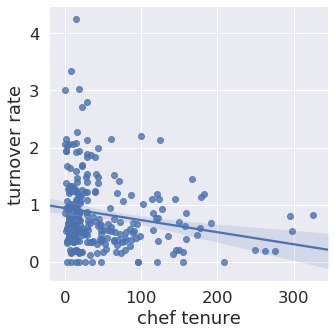

In [42]:
#Put together into a single data frame so we can plot easier
frameMVP2 = { 'turnover rate': TurnOver2, 'chef tenure': TenureMonth2['Chef Tenure']} 
dataForPlotMVP2 = pd.DataFrame(frameMVP2)
# Plot correlation between the turnover rate and the answers to the question "provide excellent service"
sb.lmplot(x='chef tenure', y='turnover rate', data=dataForPlotMVP2)


In [44]:
#Pearson's correlation coefficent and p value for the month of chef tenure and turnover rate
pearsonr(TenureMonth2['Chef Tenure'], TurnOver2)

(-0.1887869405968376, 0.00237281090600894)